# Conditional GANs for Depth Map Estimation

## Computer Vision Miniproject - Aalborg University

This script demonstrates image to image translation using conditional GANs, as described in [Image-to-Image Translation with Conditional Adversarial Networks](https://arxiv.org/abs/1611.07004). Using this technique we can colorize black and white photos, convert google maps to google earth, etc. Here, I convert monocular RGB imgaes to depth maps.

In [111]:
from __future__ import absolute_import, division, print_function

#!pip install tensorflow-gpu==2.0.0-alpha0
import tensorflow as tf
import numpy as np
import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [112]:
def load(image_file):
  image = tf.io.read_file(image_file)
  image = tf.image.decode_jpeg(image)

  w = tf.shape(image)[1]

  w = w // 2
  real_image = image[:, :w, :]
  input_image = image[:, w:, :]

  input_image = tf.cast(input_image, tf.float32)
  real_image = tf.cast(real_image, tf.float32)
  
  return input_image, real_image

In [113]:
PATH = '/home/marcell/Documents/data/'

BUFFER_SIZE = 400
BATCH_SIZE = 1

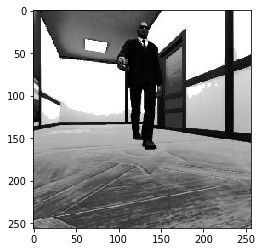

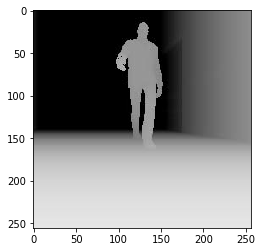

In [115]:
inp, re = load(PATH+'train/hist10.jpg')
plt.figure()
plt.imshow(inp/255.0)
plt.figure()
plt.imshow(re/255.0)

In [116]:
# normalizing the images to [-1, 1]
def normalize(input_image, real_image):
  input_image = (input_image / 127.5) - 1
  real_image = (real_image / 127.5) - 1
  
  return input_image, real_image

In [117]:
def load_image_train(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

In [118]:
def load_image_test(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = normalize(input_image, real_image)
 
  return input_image, real_image

In [119]:
train_dataset = tf.data.Dataset.list_files(PATH+'train/*.jpg')
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.batch(1)

In [120]:
test_dataset = tf.data.Dataset.list_files(PATH+'test/*.jpg')
# shuffling so that for every epoch a different image is generated 
# to predict and display the progress of our model.
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(1)

In [121]:
def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2D(filters, size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False))

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())
    
    result.add(tf.keras.layers.LeakyReLU())

    return result

In [122]:
down_model = downsample(3, 4)
down_result = down_model(tf.expand_dims(inp, 0))
print (down_result.shape)

(1, 128, 128, 3)


In [123]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same', 
                                    kernel_initializer=initializer,
                                    use_bias=False))

    result.add(tf.keras.layers.BatchNormalization())
  
    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())

    return result

In [124]:
up_model = upsample(3, 4)
up_result = up_model(down_result)
print (up_result.shape)

(1, 256, 256, 3)


In [125]:
OUTPUT_CHANNELS = 3

In [126]:
def Generator():
  down_stack = [
    downsample(64, 4, apply_batchnorm=False), # (bs, 128, 128, 64)
    downsample(128, 4), # (bs, 64, 64, 128)
    downsample(256, 4), # (bs, 32, 32, 256)
    downsample(512, 4), # (bs, 16, 16, 512)
    downsample(512, 4), # (bs, 8, 8, 512)
    downsample(512, 4), # (bs, 4, 4, 512)
    downsample(512, 4), # (bs, 2, 2, 512)
    downsample(512, 4), # (bs, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
    upsample(512, 4), # (bs, 16, 16, 1024)
    upsample(256, 4), # (bs, 32, 32, 512)
    upsample(128, 4), # (bs, 64, 64, 256)
    upsample(64, 4), # (bs, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4, 
                                         strides=2, 
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh') # (bs, 256, 256, 3)

  concat = tf.keras.layers.Concatenate() 

  inputs = tf.keras.layers.Input(shape=[None,None,3])
  x = inputs
  
  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = concat([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

W0406 11:57:14.872070 140400476317440 image.py:656] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


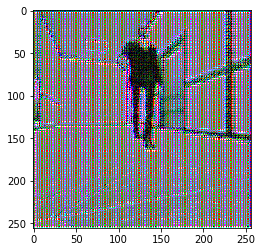

In [127]:
generator = Generator()

gen_output = generator(inp[tf.newaxis,...], training=False)
plt.imshow(gen_output[0,...])

In [128]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[None, None, 3], name='input_image')
  tar = tf.keras.layers.Input(shape=[None, None, 3], name='target_image')
  
  x = tf.keras.layers.concatenate([inp, tar]) # (bs, 256, 256, channels*2)
  
  down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
  down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
  down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1, 
                                kernel_initializer=initializer, 
                                use_bias=False)(zero_pad1) # (bs, 31, 31, 512)
  
  batchnorm1 = tf.keras.layers.BatchNormalization()(conv) 

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)
  
  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)
  
  last = tf.keras.layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)
  
  return tf.keras.Model(inputs=[inp, tar], outputs=last)

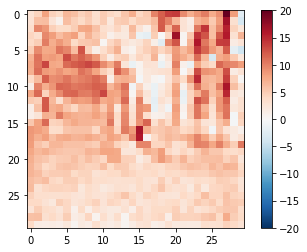

In [129]:
discriminator = Discriminator()
disc_out = discriminator([inp[tf.newaxis,...], gen_output], training=False)
plt.imshow(disc_out[0,...,-1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()

In [130]:
LAMBDA = 100
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [131]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
  
  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

In [132]:
def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)
  
  # mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss

In [133]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer, 
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator, 
                                 discriminator=discriminator)

In [134]:
def generate_images(model, test_input, tar):
  # the training=True is intentional here since
  # we want the batch statistics while running the model on the test dataset. 
  # training=False, we will get the accumulated statistics learned from 
  # the training dataset (which we don't want)
    prediction = model(test_input, training=True)
    plt.figure(figsize=(15,15))

    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

In [135]:
@tf.function
def train_step(input_image, target):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)

        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)

        gen_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    generator_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))
    
    return gen_loss, disc_loss

In [136]:
def train(dataset, epochs):
    total_t = 0
    g_total_loss = []
    d_total_loss = []
    
    min_delta = 0.01
    patience = 3
    T = 0

    for epoch in range(epochs):
        start = time.time()

        for input_image, target in dataset:
            gen_loss, disc_loss = train_step(input_image, target)
      
            clear_output(wait=True)
        for inp, tar in test_dataset.take(1):
            generate_images(generator, inp, tar)
          
        # saving (checkpoint) the model every 20 epochs
        if (epoch + 1) % 20 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)
    
        t = time.time()-start
        total_t = total_t + t
        print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1, t))
        print ('Generator Loss {} \n'.format(gen_loss))
        print ('Discriminator Loss {} \n'.format(disc_loss))
        print ('Time taken in total is {} sec'.format(total_t))
        
        g_total_loss.append(gen_loss)
        d_total_loss.append(disc_loss)
        
        # plot with various axes scales
        plt.figure(1)

        # Generator Network
        plt.subplot(221)
        plt.plot(np.arange(epoch + 1), g_total_loss)
        plt.xlabel('epochs')
        plt.ylabel('loss')
        plt.title('Generator Network')
        plt.grid(True)

        # Disciminator Network
        plt.subplot(222)
        plt.plot(np.arange(epoch + 1), d_total_loss, color='red')
        plt.xlabel('epochs')
        plt.ylabel('loss')
        plt.title('Discriminator Network')
        plt.grid(True)
        
        plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25, wspace=0.35)
        plt.show()
        
        """
        if epoch > 0 and d_total_loss[epoch-1] - d_total_loss[epoch] > min_delta:
            T = 0
        else:
            T += 1
        
        if patience < T:
            print("Early stopping...")
            break
        """
        

W0406 15:18:32.834058 140400476317440 image.py:656] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


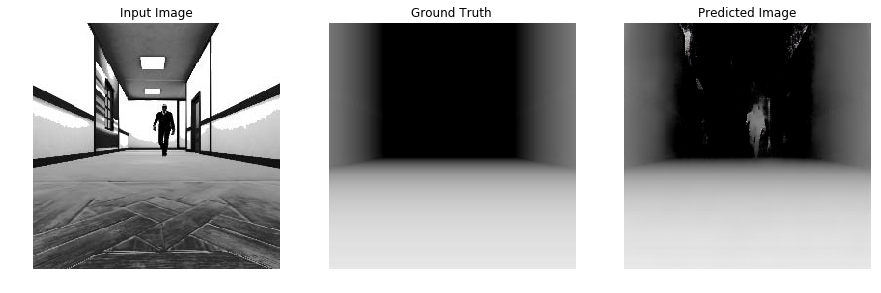

Time taken for epoch 200 is 63.55298972129822 sec

Generator Loss 7.859513759613037 

Discriminator Loss 0.24045443534851074 

Time taken in total is 12017.046197652817 sec


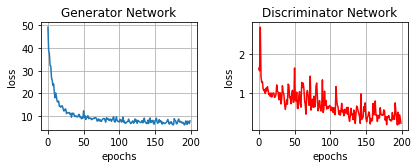

In [137]:
EPOCHS = 200
train(train_dataset, EPOCHS)

In [138]:
!ls {checkpoint_dir}

checkpoint		     ckpt-27.index
ckpt-10.data-00000-of-00001  ckpt-28.data-00000-of-00001
ckpt-10.index		     ckpt-28.index
ckpt-11.data-00000-of-00001  ckpt-29.data-00000-of-00001
ckpt-11.index		     ckpt-29.index
ckpt-12.data-00000-of-00001  ckpt-2.data-00000-of-00001
ckpt-12.index		     ckpt-2.index
ckpt-13.data-00000-of-00001  ckpt-30.data-00000-of-00001
ckpt-13.index		     ckpt-30.index
ckpt-14.data-00000-of-00001  ckpt-31.data-00000-of-00001
ckpt-14.index		     ckpt-31.index
ckpt-15.data-00000-of-00001  ckpt-32.data-00000-of-00001
ckpt-15.index		     ckpt-32.index
ckpt-16.data-00000-of-00001  ckpt-33.data-00000-of-00001
ckpt-16.index		     ckpt-33.index
ckpt-17.data-00000-of-00001  ckpt-34.data-00000-of-00001
ckpt-17.index		     ckpt-34.index
ckpt-18.data-00000-of-00001  ckpt-35.data-00000-of-00001
ckpt-18.index		     ckpt-35.index
ckpt-19.data-00000-of-00001  ckpt-36.data-00000-of-00001
ckpt-19.index		     ckpt-36.index
ckpt-1.data-00000-of-00001   ckpt-37.data-00000-of-00001
ckpt

In [139]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

W0406 15:26:12.870391 140400476317440 image.py:656] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


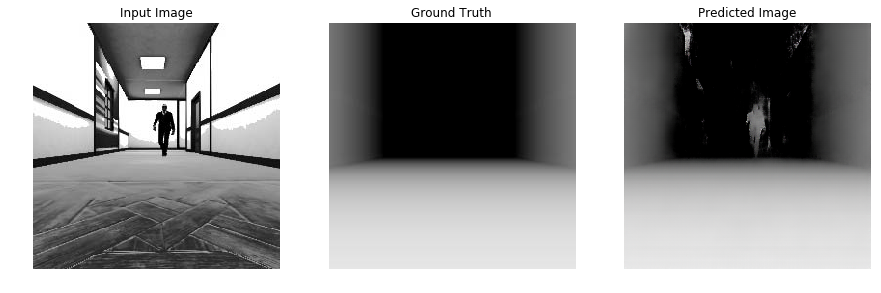

W0406 15:26:13.324053 140400476317440 image.py:656] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


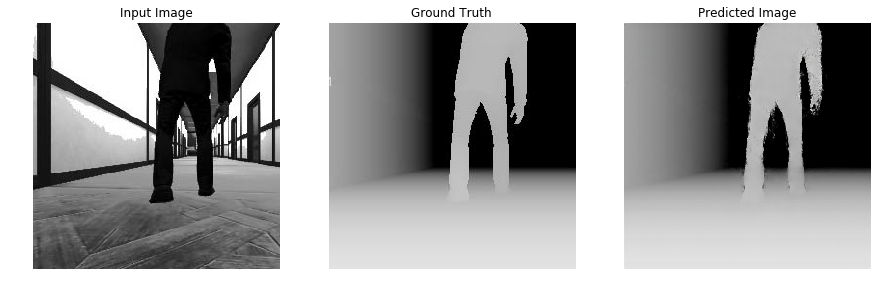

W0406 15:26:13.793011 140400476317440 image.py:656] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


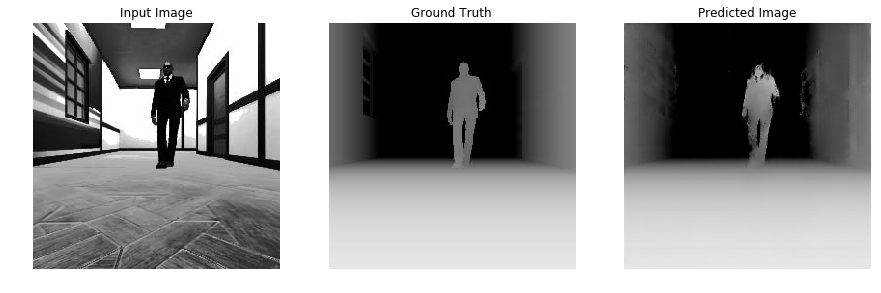

W0406 15:26:14.264155 140400476317440 image.py:656] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


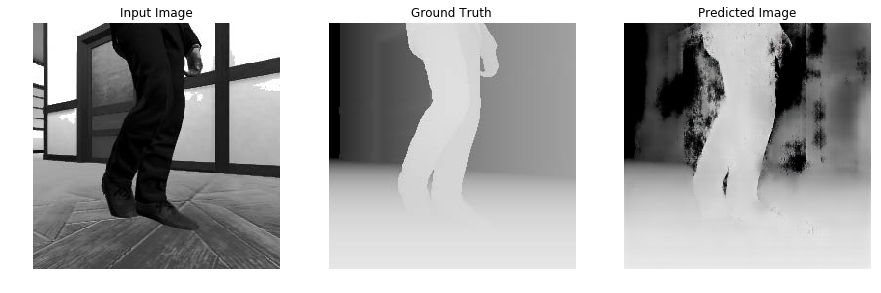

W0406 15:26:14.730160 140400476317440 image.py:656] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


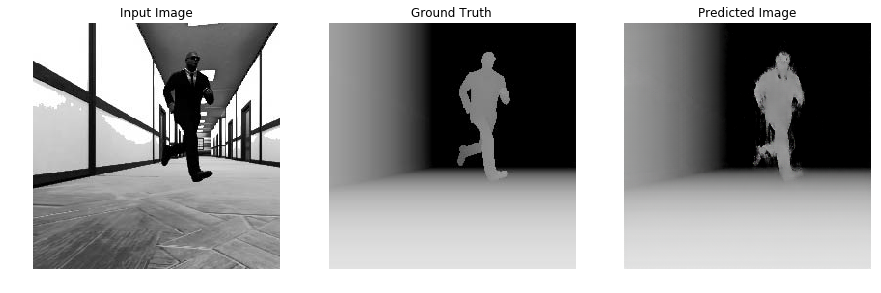

W0406 15:26:15.229183 140400476317440 image.py:656] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


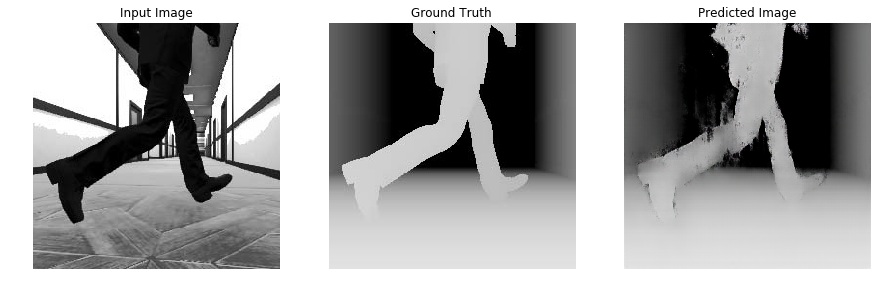

In [140]:
# Run the trained model on the entire test dataset
for inp, tar in test_dataset:
    generate_images(generator, inp, tar)

W0403 04:09:47.973762 140175256405760 image.py:656] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


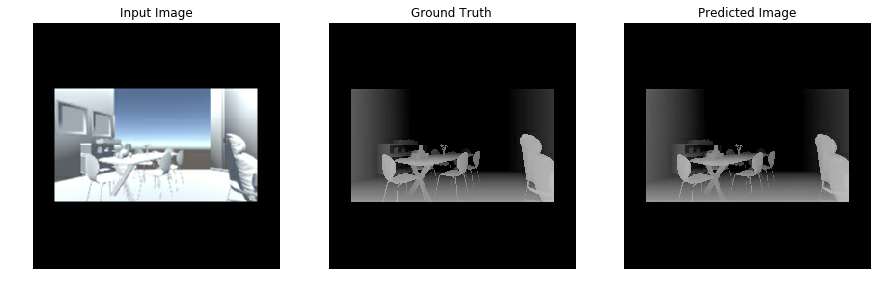

W0403 04:09:48.464273 140175256405760 image.py:656] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


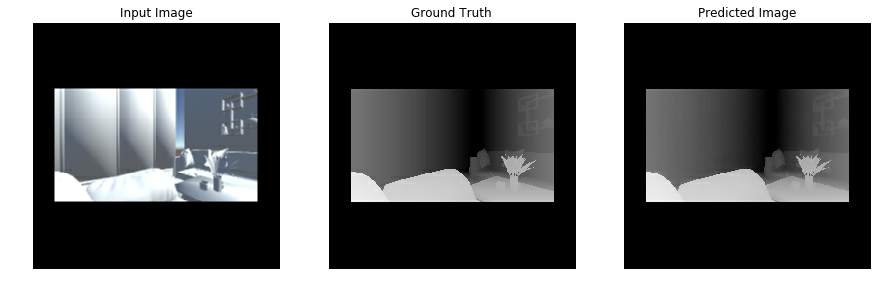

W0403 04:09:48.925927 140175256405760 image.py:656] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


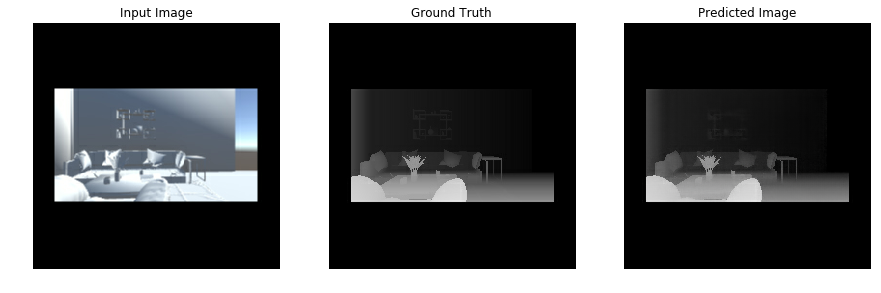

W0403 04:09:49.406048 140175256405760 image.py:656] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


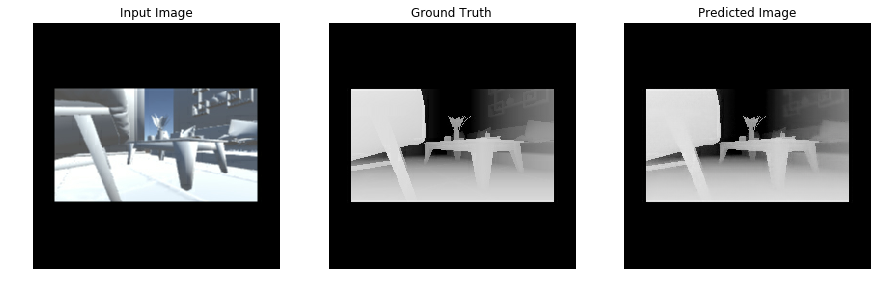

W0403 04:09:49.854166 140175256405760 image.py:656] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


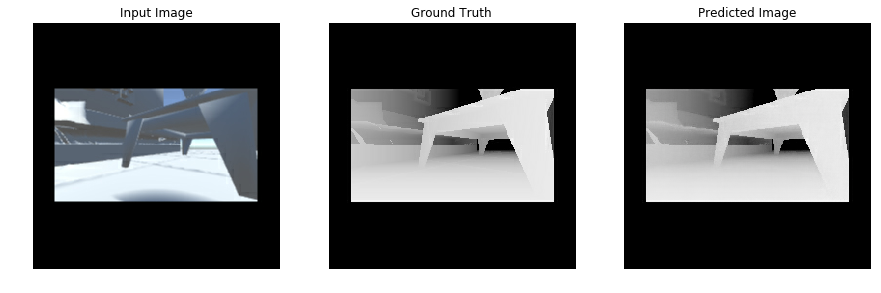

W0403 04:09:50.291080 140175256405760 image.py:656] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


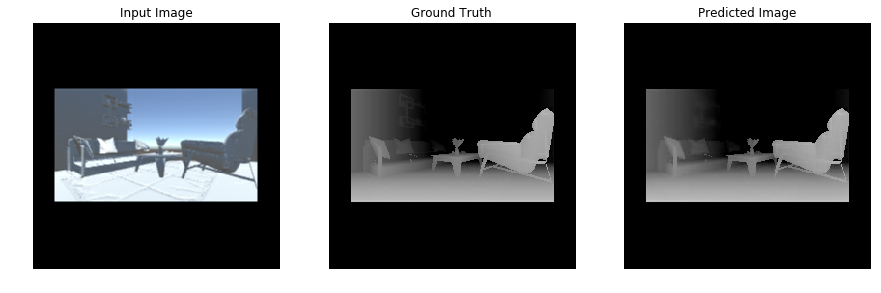

W0403 04:09:50.723389 140175256405760 image.py:656] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


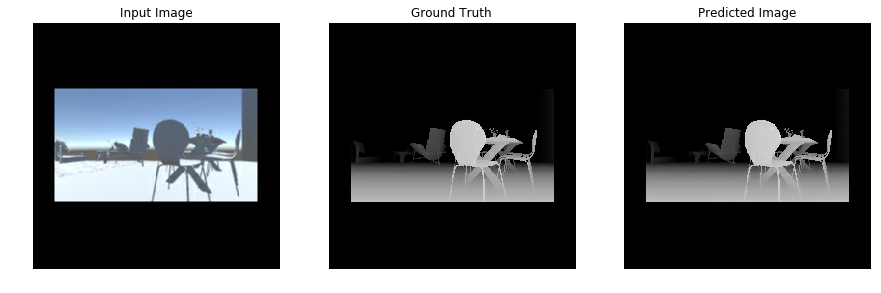

W0403 04:09:51.139055 140175256405760 image.py:656] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


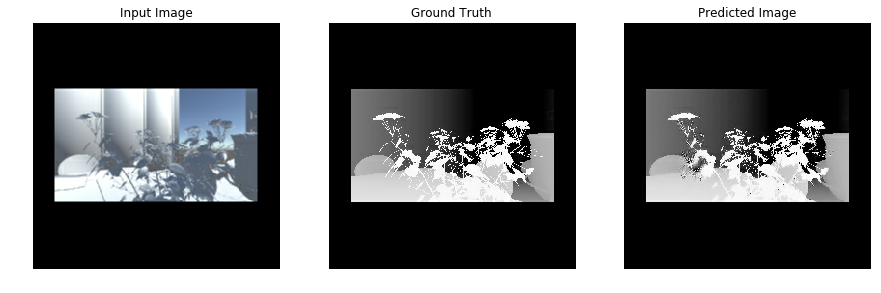

W0403 04:09:51.602762 140175256405760 image.py:656] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


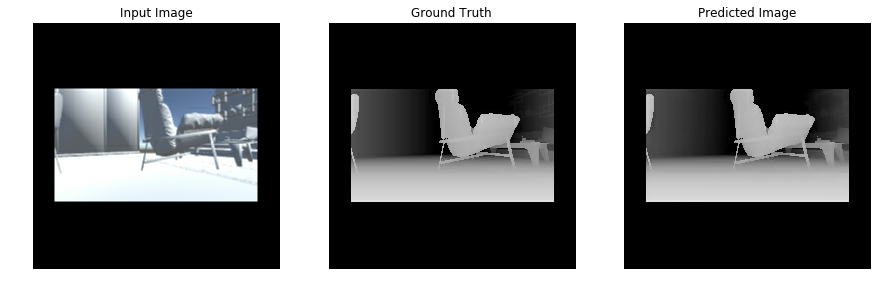

W0403 04:09:52.068038 140175256405760 image.py:656] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


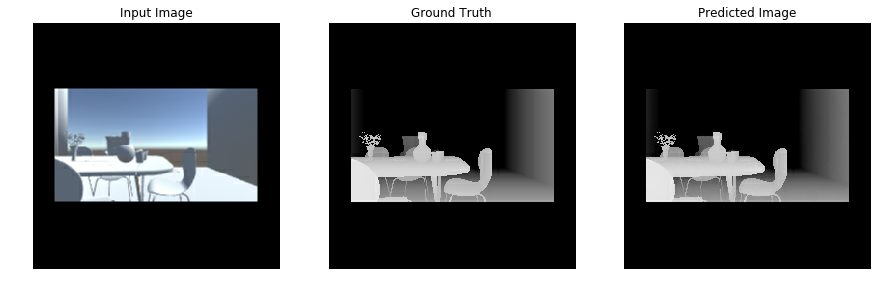

W0403 04:09:52.489536 140175256405760 image.py:656] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


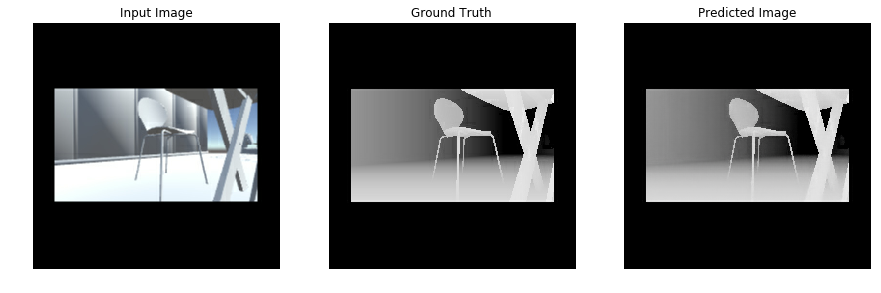

W0403 04:09:52.955884 140175256405760 image.py:656] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


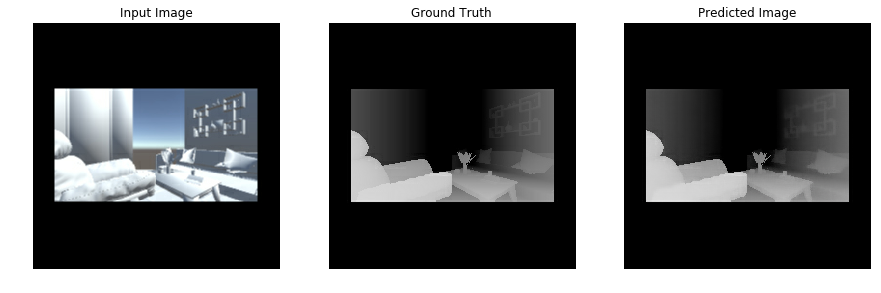

W0403 04:09:53.379019 140175256405760 image.py:656] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


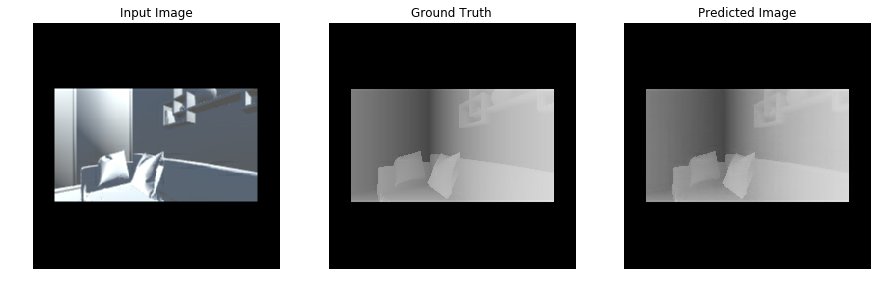

W0403 04:09:53.809747 140175256405760 image.py:656] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


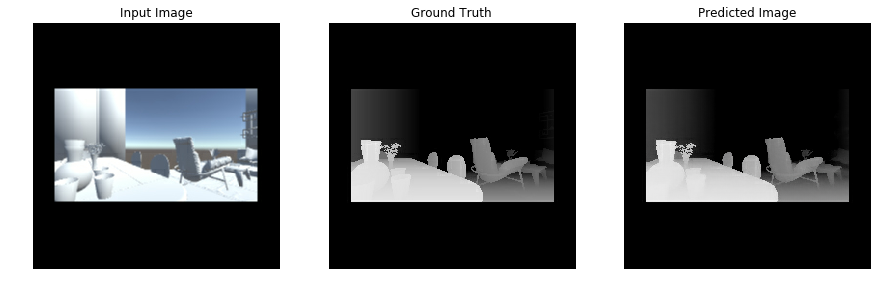

W0403 04:09:54.474547 140175256405760 image.py:656] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


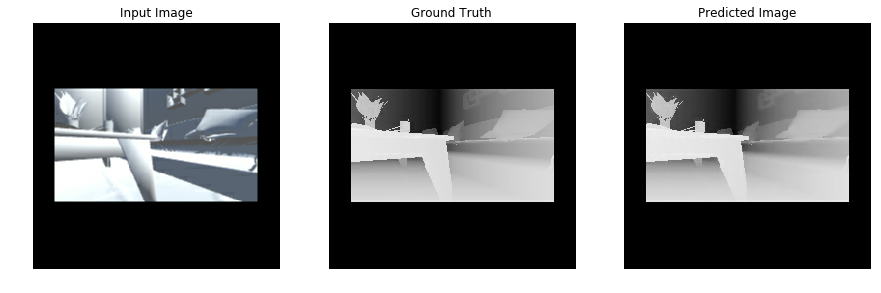

W0403 04:09:54.910182 140175256405760 image.py:656] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


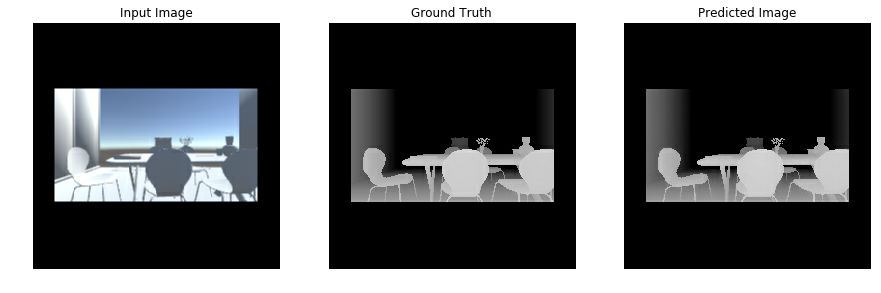

W0403 04:09:55.392651 140175256405760 image.py:656] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


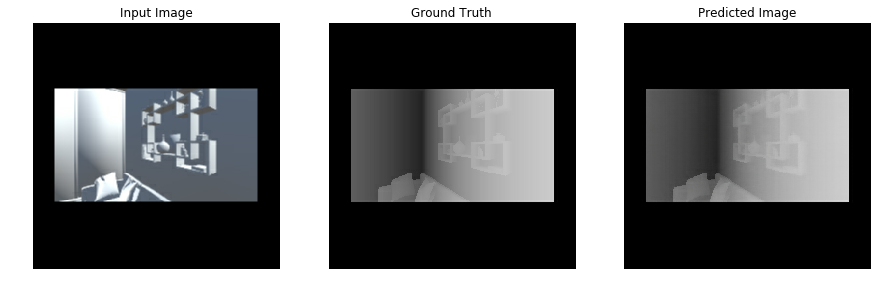

W0403 04:09:55.884002 140175256405760 image.py:656] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


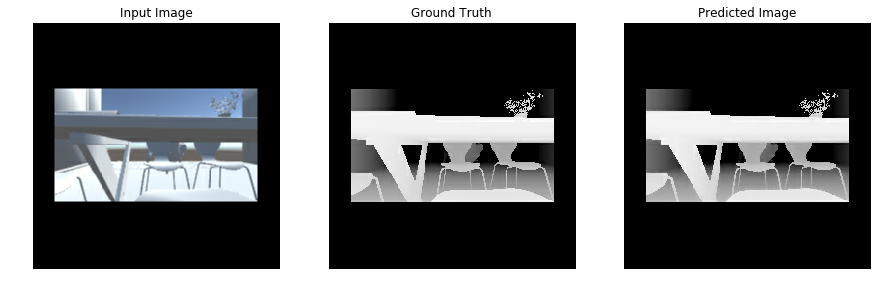

W0403 04:09:56.340117 140175256405760 image.py:656] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


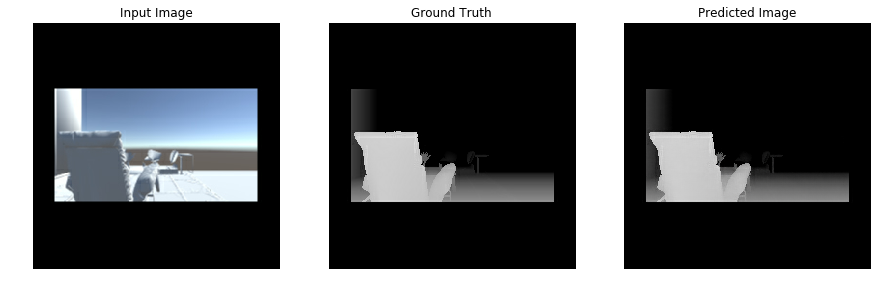

W0403 04:09:56.768244 140175256405760 image.py:656] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


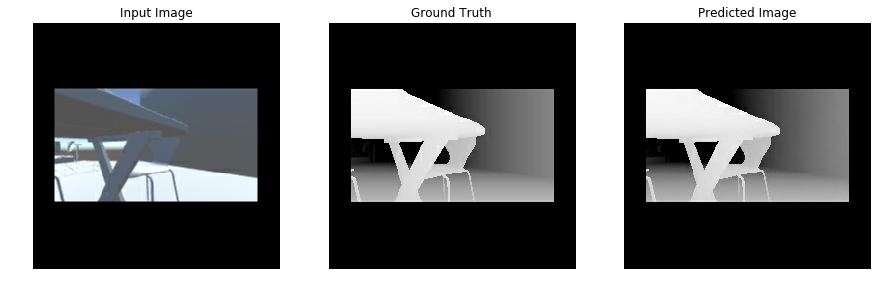

W0403 04:09:57.234507 140175256405760 image.py:656] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


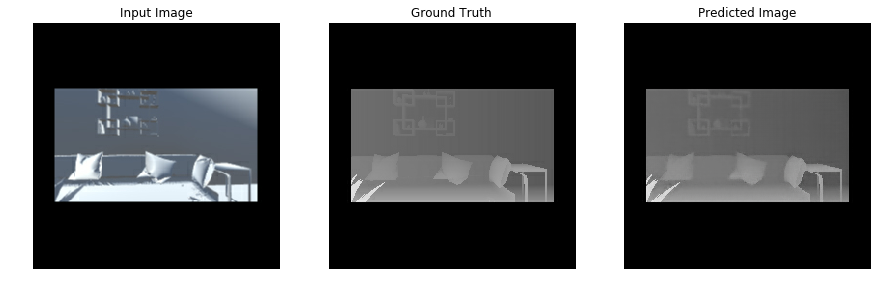

W0403 04:09:57.717764 140175256405760 image.py:656] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


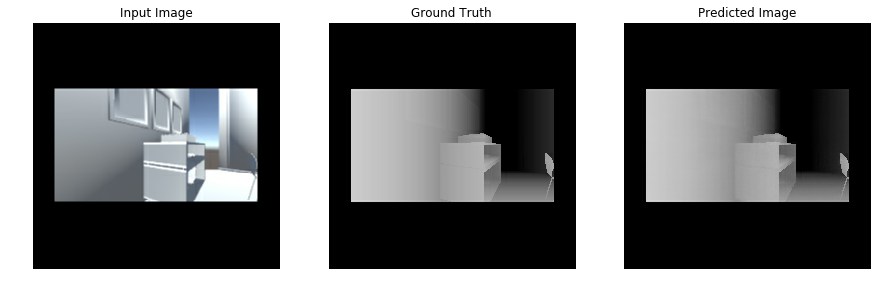

W0403 04:09:58.219468 140175256405760 image.py:656] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


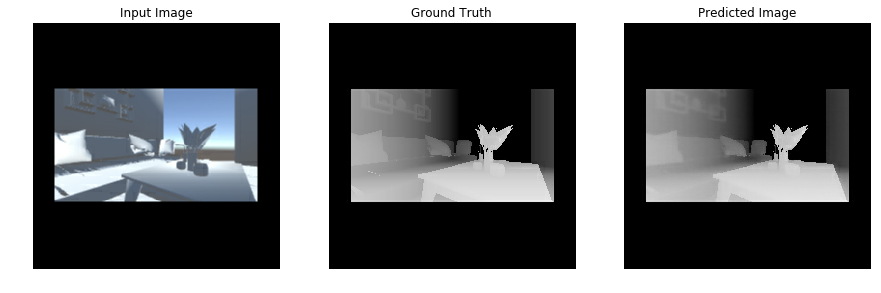

W0403 04:09:58.645501 140175256405760 image.py:656] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


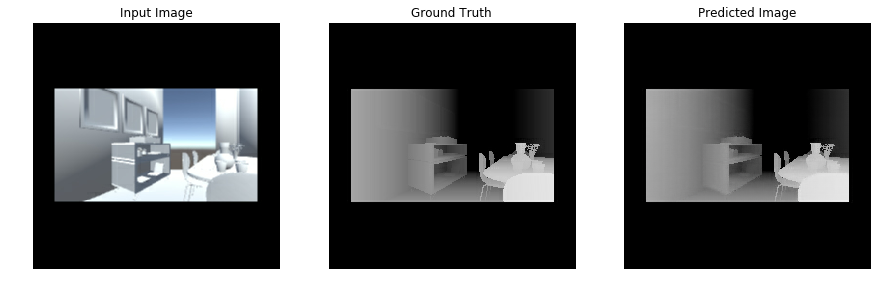

W0403 04:09:59.085508 140175256405760 image.py:656] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


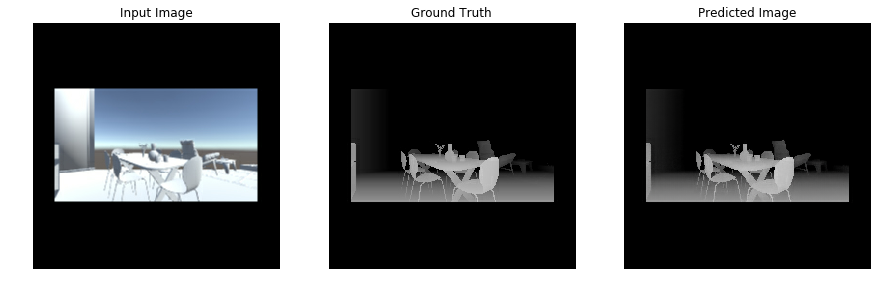

W0403 04:09:59.560883 140175256405760 image.py:656] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


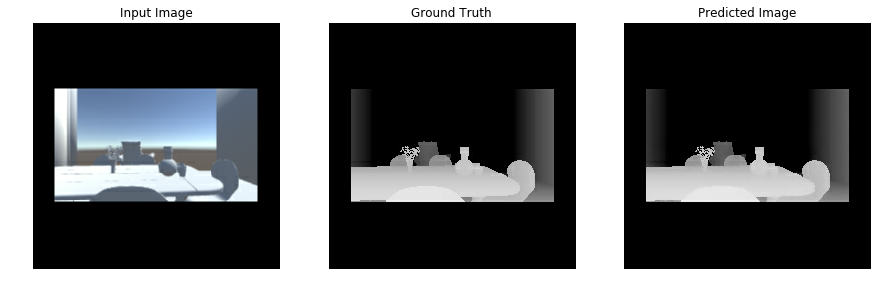

W0403 04:09:59.979556 140175256405760 image.py:656] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


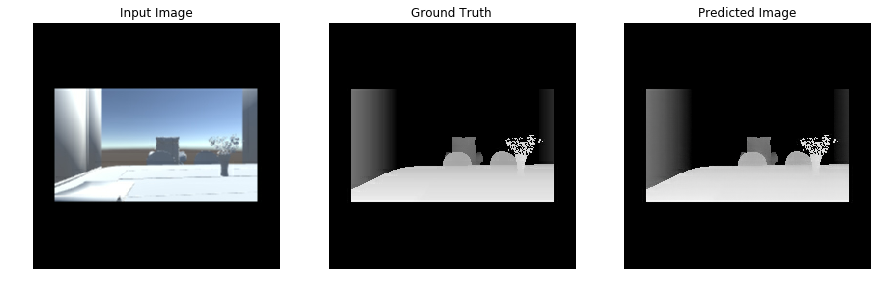

W0403 04:10:00.405860 140175256405760 image.py:656] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


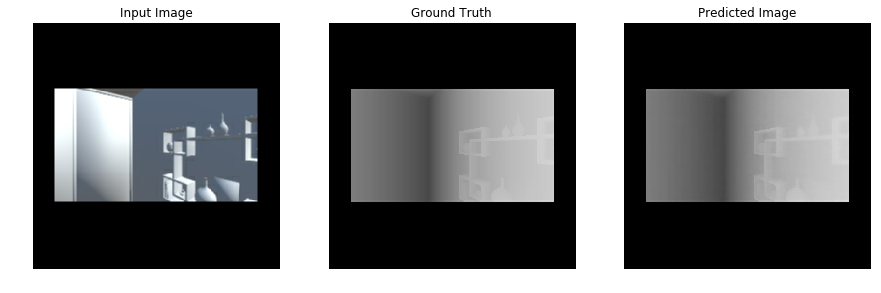

W0403 04:10:00.843316 140175256405760 image.py:656] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


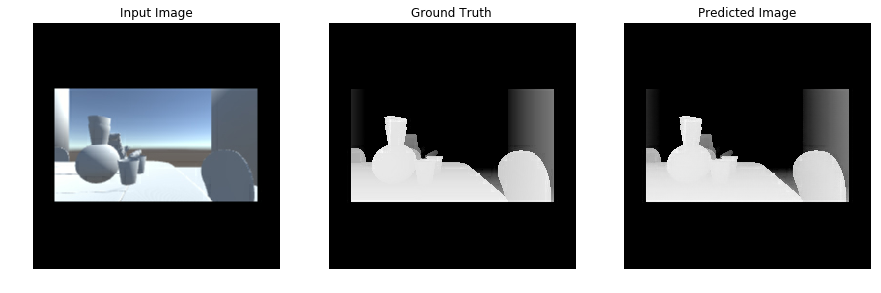

W0403 04:10:01.272365 140175256405760 image.py:656] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


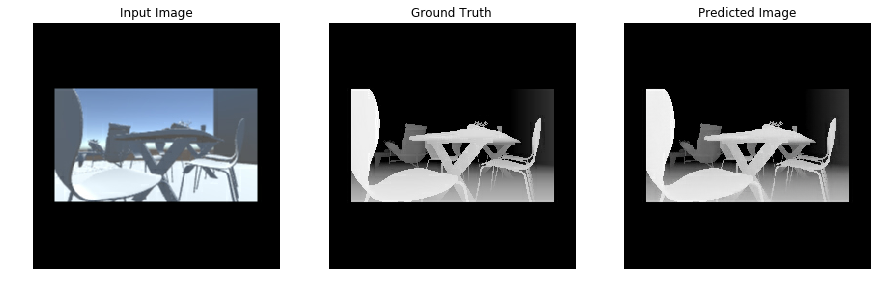

W0403 04:10:01.712340 140175256405760 image.py:656] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


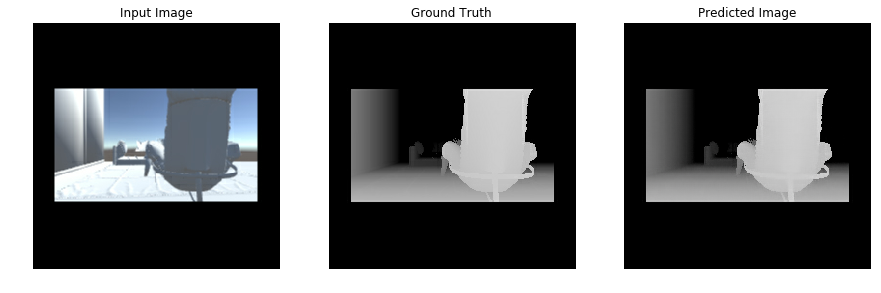

In [48]:
for inp, tar in train_dataset:
  generate_images(generator, inp, tar)